Подключим необходимые библиотеки и загрузим данные

In [ ]:
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
from matplotlib import pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import numpy as np
import holidays
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', sep = ',').drop('Id', 1)

In [ ]:
data.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,2020-01-22,0.0,0.0
1,NaN,Afghanistan,2020-01-23,0.0,0.0
2,NaN,Afghanistan,2020-01-24,0.0,0.0
3,NaN,Afghanistan,2020-01-25,0.0,0.0
4,NaN,Afghanistan,2020-01-26,0.0,0.0


# Прогноз по всему миру (Максим Смыслов)

## Загрузим данные и посмотрим на них

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid19/train.csv', sep = ',', index_col=0)
df_total = df.groupby(['Date'],as_index=False).agg({'ConfirmedCases':'sum','Fatalities':'sum'})
test = df_total[df_total['Date'] >= '2020-04-16']
train = df_total[df_total['Date'] < '2020-04-16']

Тут я разбил данные на тренировочную и тестовые части. Оставил 30 дней на тест

In [ ]:
train

,Date,ConfirmedCases,Fatalities
0,2020-01-22,554.0,17.0
1,2020-01-23,653.0,18.0
2,2020-01-24,939.0,26.0
3,2020-01-25,1432.0,42.0
4,2020-01-26,2113.0,56.0
...,...,...,...
80,2020-04-11,1735855.0,110260.0
81,2020-04-12,1834968.0,115783.0
82,2020-04-13,1904983.0,121216.0
83,2020-04-14,1975389.0,128005.0


In [ ]:
test.head()

,Date,ConfirmedCases,Fatalities
85,2020-04-16,2151822.0,146032.0
86,2020-04-17,2239455.0,156163.0
87,2020-04-18,2317063.0,162122.0
88,2020-04-19,2400884.0,167485.0
89,2020-04-20,2471547.0,172529.0


## Визуализируем данные

### График количества подтверждённых заболеваний.

In [ ]:
iplot([
    go.Scatter(x=train.Date , y=train.ConfirmedCases, name='confirmed cases')
]);

### График количества смертей

In [ ]:
iplot([go.Scatter(x=train.Date , y=train.Fatalities, name='fatalities')])

По графикам видно, что они особо без скачков растут вверх. При таком приближении не видно ни сезонности, ни каких-то закономерностей, а только растущий тренд.

## Будем сначала прогнозировать через Prophet 

Посмотрим прогноз на 30 дней "из коробки" по количеству подтверждённых заболеваний

In [ ]:
prediction_period = 30
m = Prophet()
confirm_total = pd.DataFrame()
confirm_total['ds'] = train.Date
confirm_total['y'] = train.ConfirmedCases
m.fit(confirm_total)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


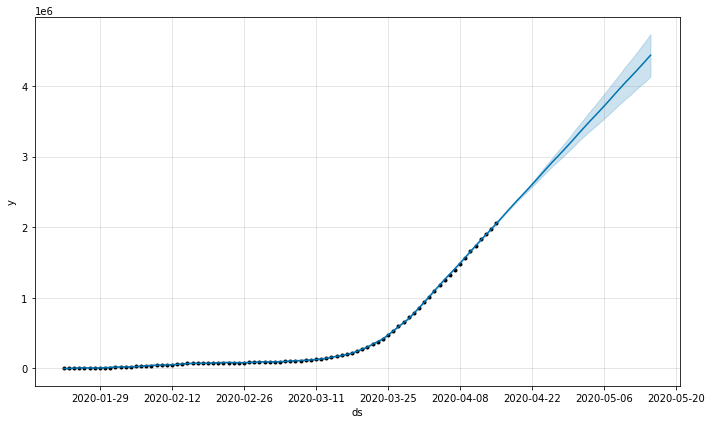

In [ ]:
future = m.make_future_dataframe(periods=prediction_period)
forecast = m.predict(future)
m.plot(forecast)
plt.show()


По графику видно что  прогноз очень похож на тестовые значения. Проверим точность с помощью метрик MAE и MAPE.

In [ ]:
full_df_confirm = pd.DataFrame()
full_df_confirm['ds'] = df_total['Date']
full_df_confirm['y'] = df_total.ConfirmedCases

In [ ]:
new_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper','trend']].join(full_df_confirm.set_index('ds'))

new_df['e'] = new_df['y'] - new_df['yhat']
new_df['p'] = 100 * new_df['e']/new_df['y']

abs_p = abs(new_df[-prediction_period:]['p'])
abs_e = abs(new_df[-prediction_period:]['e'])
print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-prediction_period:]['p'])),2))+'%')
print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-prediction_period:]['e'])),2))

MAPE - ошибка в процентах 1.01%
MAE - абсолютная ошибка 35267.8


Из коробки у нас ошибка прогноза на месяц равна 1.01% по кумулятивным данным. Посмотрим как Prophet разложил наши данные.

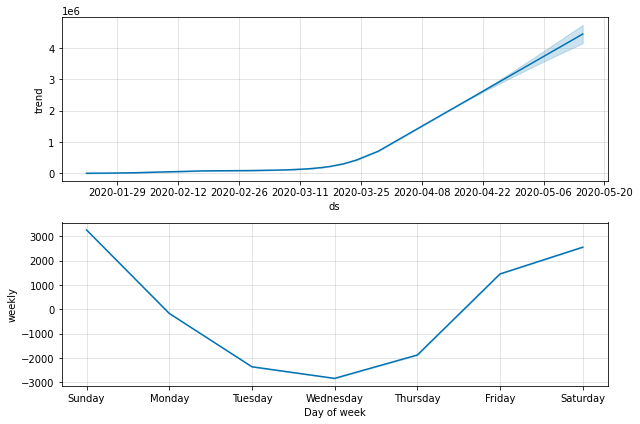

In [ ]:
m.plot_components(forecast);

Видно, что модель разложила данные на тренд, который явно вносит 99% влияния и небольшую сезональность внутри недели. Видим, что в основном заражения выявлялись в выходные, а не в середине недели. С одной стороны можно конечно предположить, что люди по выходным больше собираются группами, однако это же данные скорее всего когда получился положительный тест, а их делают несколько дней, так что скорее всего гипотеза не верна

## Попробуем посмотреть на больший срок

Берём весь датафрейм на обучение

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


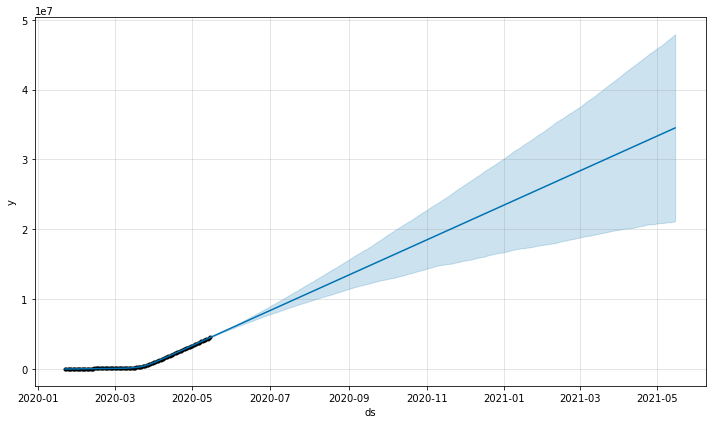

In [ ]:
prediction_period = 365 
m = Prophet()
m.fit(full_df_confirm)
future = m.make_future_dataframe(periods=prediction_period)
forecast = m.predict(future)
m.plot(forecast)
plt.show()

Получаем просто линейный прогноз заболеваемости, что не особо интересно, так как он не особо интерпретируемый и не показывает вспышки заболеваемости или спады. По прогнозам данной модели через год будет примерно 35млн обнаруженных заражений. Далее будем смотреть на динамику заболеваемости по дням. 

## По изменениям за день

Рассмотрим пока количество обнаруженных заражённых

In [ ]:
df_total_diff = pd.DataFrame()
df_total_diff['ds'] = df_total.Date
df_total_diff['y'] = df_total.ConfirmedCases.diff().fillna(df_total.ConfirmedCases)


In [ ]:
df_total_diff

,ds,y
0,2020-01-22,554.0
1,2020-01-23,99.0
2,2020-01-24,286.0
3,2020-01-25,493.0
4,2020-01-26,681.0
...,...,...
110,2020-05-11,75746.0
111,2020-05-12,84366.0
112,2020-05-13,84995.0
113,2020-05-14,95024.0


## График обнаруженных заражённых за каждый день

In [ ]:
df_total_diff['moving_avg_users'] = df_total_diff['y'].rolling(window=7).mean()
iplot(
    [go.Scatter(x=df_total_diff.ds , y=df_total_diff.y, name='confirm'),
     go.Scatter(x=df_total_diff.ds , y=df_total_diff.moving_avg_users, name='avg')
     ]
    )

Видно, что с начала апреля и до середины мая была стагнация заболеваемости, чего явно не было видно раньше.

## Попробуем прогнозировать такой ряд

In [ ]:
test_diff = df_total_diff[df_total_diff['ds'] >= '2020-04-16']
train_diff = df_total_diff[df_total_diff['ds'] < '2020-04-16']

In [ ]:
train_diff.head()

,ds,y,moving_avg_users
0,2020-01-22,554.0,NaN
1,2020-01-23,99.0,NaN
2,2020-01-24,286.0,NaN
3,2020-01-25,493.0,NaN
4,2020-01-26,681.0,NaN


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


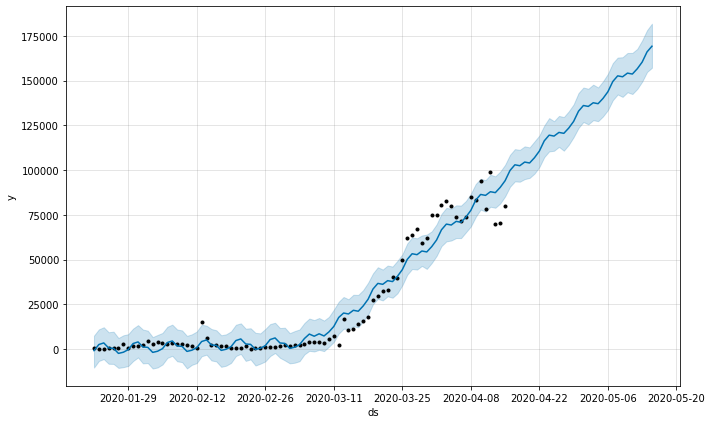

In [ ]:
prediction_period = 30
m = Prophet()
m.fit(train_diff)
future = m.make_future_dataframe(periods=prediction_period)
forecast = m.predict(future)
m.plot(forecast)
plt.show()

Очевидно такая модель плохо отражает данные. Проверим её качество.

In [ ]:
new_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper','trend']].join(df_total_diff.set_index('ds'))

new_df['e'] = new_df['y'] - new_df['yhat']
new_df['p'] = 100 * new_df['e']/new_df['y']


abs_p = abs(new_df[-prediction_period:]['p'])
abs_e = abs(new_df[-prediction_period:]['e'])

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-prediction_period:]['p'])),2))+'%')

print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-prediction_period:]['e'])),2))

MAPE - ошибка в процентах 59.72%
MAE - абсолютная ошибка 49037.18


Получился довольно плохой прогноз, попробуем поменять гиперпараметры. Для этого просто переберём некоторые параметры.

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_range': [0.25, 0.5, 0.75,0.8,0.9,0.95],
              'seasonality_prior_scale' :[1,10,20,80,100],
              'n_changepoints' : [10,25]
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 120


In [ ]:


model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in tqdm(grid):
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(
       # changepoint_prior_scale = p['changepoint_prior_scale'],
                        n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         changepoint_range = p['changepoint_range'],
                       seasonality_prior_scale = p['seasonality_prior_scale'],
                         interval_width=0.95)


    train_model.fit(train_diff)
    train_forecast = train_model.make_future_dataframe(periods=prediction_period, freq='d')
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    #Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    #MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    cmp_df = train_forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_total_diff.set_index('ds'))

    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100 * cmp_df['e']/cmp_df['y']


    abs_p = abs(cmp_df[-prediction_period:]['p'])
    abs_e = abs(cmp_df[-prediction_period:]['e'])
    yhat_low = cmp_df['yhat_lower']
    MAPE = np.mean(abs(cmp_df[-prediction_period:]['p']))
  
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters

,MAPE,Parameters
0,9.833045,"{'changepoint_range': 0.25, 'n_changepoints': ..."
1,9.844902,"{'changepoint_range': 0.25, 'n_changepoints': ..."
2,9.844902,"{'changepoint_range': 0.25, 'n_changepoints': ..."
3,9.844932,"{'changepoint_range': 0.25, 'n_changepoints': ..."
4,9.844937,"{'changepoint_range': 0.25, 'n_changepoints': ..."
...,...,...
115,64.901319,"{'changepoint_range': 0.95, 'n_changepoints': ..."
116,65.301250,"{'changepoint_range': 0.8, 'n_changepoints': 1..."
117,65.301288,"{'changepoint_range': 0.8, 'n_changepoints': 1..."
118,65.302303,"{'changepoint_range': 0.8, 'n_changepoints': 1..."


Получили минимальное значение MAPE в 9.83%, попробуем самые наилучшие параметры.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


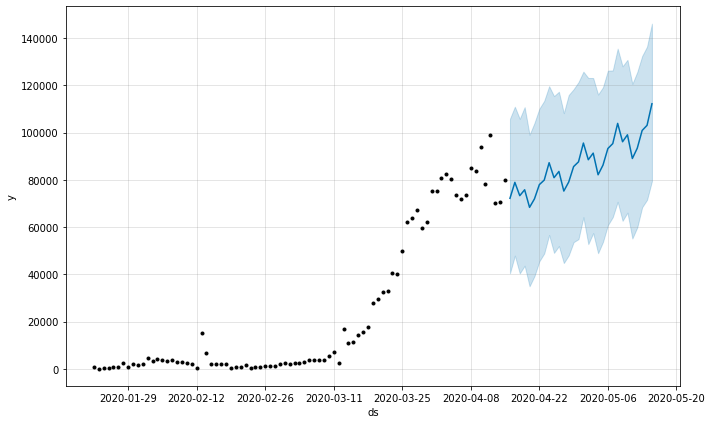

In [ ]:
prediction_period = 30
m = Prophet(
    changepoint_range=0.25,
    n_changepoints=10,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=1,
    interval_width=0.95
    )
m.fit(train_diff)
future = m.make_future_dataframe(periods=prediction_period)
forecast = m.predict(future)
m.plot(forecast[forecast['ds'] > '2020-04-15'])
plt.show()

## Посмотрим на прогноз на год

Обучимся на всех данных




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


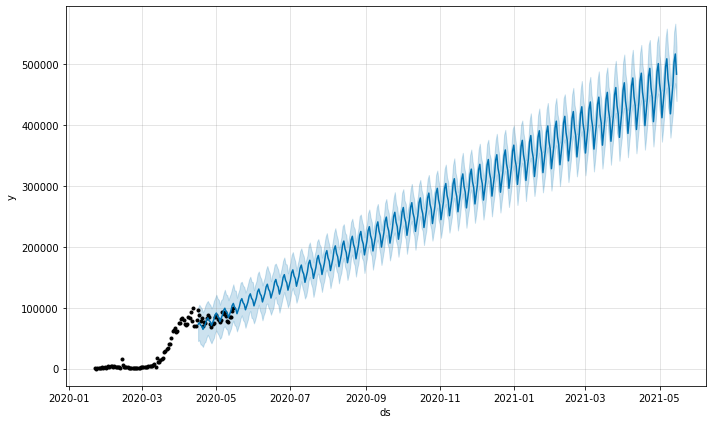

In [ ]:
prediction_period = 365
m = Prophet(
     changepoint_range=0.25,
    n_changepoints=10,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=1,
    interval_width=0.95
    )
m.fit(df_total_diff)
future = m.make_future_dataframe(periods=prediction_period)
forecast = m.predict(future)
m.plot(forecast[forecast['ds'] > '2020-04-15'])
plt.show()

Получили волнообразный прогноз, что в целом может соответствовать новым вспышкам заболевания.

In [ ]:
print('Оценочное количество найденных заражений через год по всему миру при такой модели: ',int(forecast.yhat.sum()))

Оценочное количество найденных заражений через год по всему миру при такой модели:  108994704


Думаю можно было бы добавить насыщение, только здесь ещё всё равно очень малое количество данных по сравнению с количеством людей во всём мире и насыщение не будет заметно.

## Попробуем сделать модель прогнозирования смертности

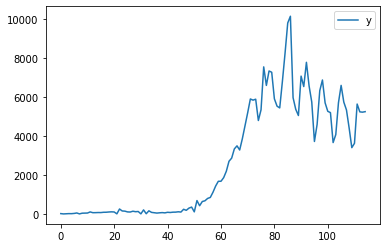

In [ ]:
df_total_diff_death = pd.DataFrame()
df_total_diff_death['ds'] = df_total.Date
df_total_diff_death['y'] = df_total.Fatalities.diff().fillna(df_total.Fatalities)
df_total_diff_death.plot()

Я выкину первые 20 дней, когда, как я думаю была самая необоснованная статистика смертности, когда совсем не было понятно от чего умирали.

## Переберём параметры модели, т.к. из коробки MAPE была больше 100%

In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in tqdm(grid):
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(
       # changepoint_prior_scale = p['changepoint_prior_scale'],
                        n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         changepoint_range = p['changepoint_range'],
                       seasonality_prior_scale = p['seasonality_prior_scale'],
                         interval_width=0.95)


    train_model.fit(df_total_diff_death[20:-prediction_period])
    train_forecast = train_model.make_future_dataframe(periods=prediction_period, freq='d')
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    #Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    #MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    cmp_df = train_forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_total_diff_death.set_index('ds'))

    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100 * cmp_df['e']/cmp_df['y']


    abs_p = abs(cmp_df[-prediction_period:]['p'])
    abs_e = abs(cmp_df[-prediction_period:]['e'])
    yhat_low = cmp_df['yhat_lower']
    MAPE = np.mean(abs(cmp_df[-prediction_period:]['p']))
  
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,50.485366,"{'changepoint_range': 0.25, 'n_changepoints': ..."
1,50.492409,"{'changepoint_range': 0.25, 'n_changepoints': ..."
2,50.492410,"{'changepoint_range': 0.25, 'n_changepoints': ..."
3,50.492453,"{'changepoint_range': 0.25, 'n_changepoints': ..."
4,50.492594,"{'changepoint_range': 0.25, 'n_changepoints': ..."


Перебирая параметры мне удалось получить только 50% MAPE, но даже так уже хорошо, т.к. не выкидывая первые 20 дней получалось гораздо хуже. Однако может я не до конца перебрал все параметры, но остановлюсь на этом, может в ARIMA будет лучше.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


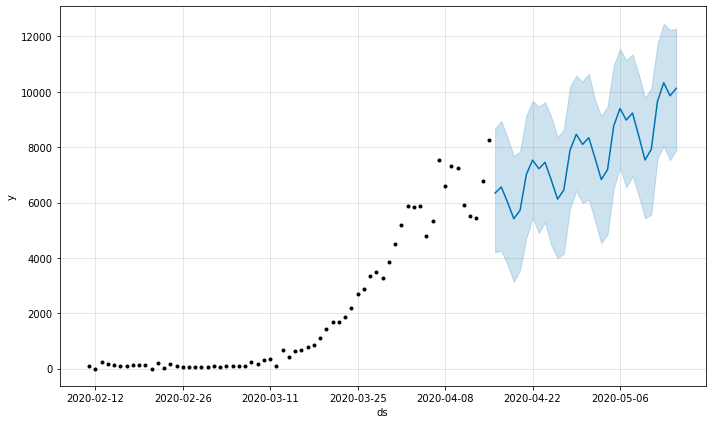

In [ ]:
prediction_period = 30
m = Prophet(
    changepoint_range=0.25,
    n_changepoints=10,
    seasonality_prior_scale=1,
    seasonality_mode= 'multiplicative',
    interval_width=0.95
)

m.fit(df_total_diff_death[20:-prediction_period])
future = m.make_future_dataframe(periods=prediction_period)
forecast = m.predict(future)
m.plot(forecast[forecast['ds'] > '2020-04-15'])
plt.show()

## Построим прогноз на год

Дообучимся на всех имеющихся данных

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


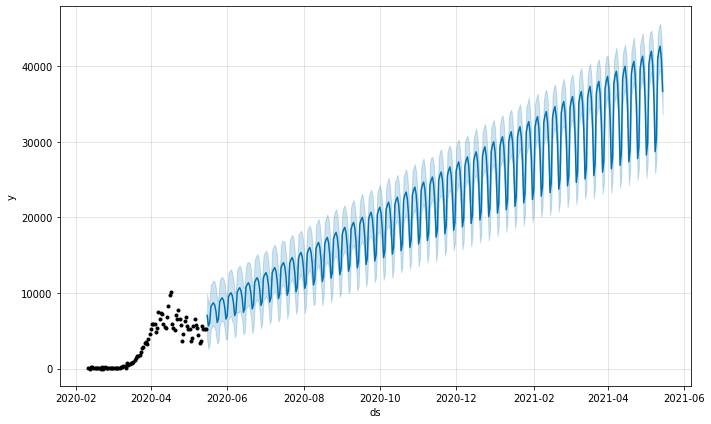

In [ ]:
prediction_period = 365
m = Prophet(
    changepoint_range=0.25,
    n_changepoints=10,
    seasonality_prior_scale=1,
    seasonality_mode= 'multiplicative',
    interval_width=0.95
)

m.fit(df_total_diff_death[20:])
future = m.make_future_dataframe(periods=prediction_period)
forecast = m.predict(future)
m.plot(forecast[forecast['ds'] > '2020-05-15'])
plt.show()

In [ ]:
print('Через год модель предсказывает, что будет {} смертей от коронавируса' \
      .format(int(forecast[forecast['ds'] > '2020-05-15'].yhat.sum() + \
                  df_total_diff_death.y.sum())))

Через год модель предсказывает, что будет 8511745 смертей от коронавируса


## ARIMA


## Пока возьмём только Confirmed cases

In [ ]:
!pip install stldecompose
!pip install ml_metrics

Подключим недостающие библиотеки

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from datetime import datetime

from sklearn.metrics import r2_score
import ml_metrics as metrics

Будем работать с изменениями за день, т.к. считаю такие данные интереснее для исследования

Для начала нам необходимо подобрать наилучшую степень аппроксимирующего полинома

Best degree 	12 with RMSE 5899.750909660656,
		 13 with MAE 3939.3530053063078,
		 12 with R2 0.9784517170164864


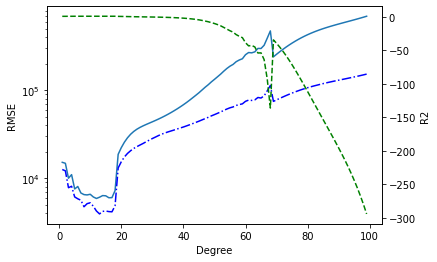

In [ ]:
dta = df_total_diff

n_data = len(dta['ds'].values.astype('datetime64[D]'))
X = np.arange(n_data).reshape(n_data, 1)
y = np.array(dta['y'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rmses = []
maes = []
r2_scores = []
degrees = np.arange(1, 100)
min_rmse, min_mae, min_r2, min_deg, min_deg_mae, min_deg_r2 = 1e10, 1e10, 0.01, 0, 0, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    
    # 1. RMSE:
    poly_mse = mean_squared_error(y_test, poly_predict) # Mean Square Error
    poly_rmse = np.sqrt(poly_mse) # Root Mean Square Root
    rmses.append(poly_rmse)
    
    # 2. MAE:
    poly_mae = mean_absolute_error(y_test, poly_predict)
    maes.append(poly_mae)
    
    # 3. R2 - score:
    poly_r2_score = r2_score(y_test.tolist(), poly_predict.tolist())
    r2_scores.append(poly_r2_score)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    if min_mae > poly_mae:
        min_mae = poly_mae
        min_deg_mae = deg
    if min_r2 < poly_r2_score:
        min_r2 = poly_r2_score
        min_deg_r2 = deg

# Plot and present results
print('Best degree \t{} with RMSE {},\n\t\t {} with MAE {},\n\t\t {} with R2 {}'.format(min_deg, min_rmse, min_deg_mae, min_mae, min_deg_r2, min_r2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax2 = ax.twinx()
ax.plot(degrees, maes, 'b-.')
ax2.plot(degrees, r2_scores, 'g--')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax2.set_ylabel('R2')
ax.set_ylabel('MAE')
ax.set_ylabel('RMSE')
plt.show()

Далее нам необходимо подогнать наш полином под данные

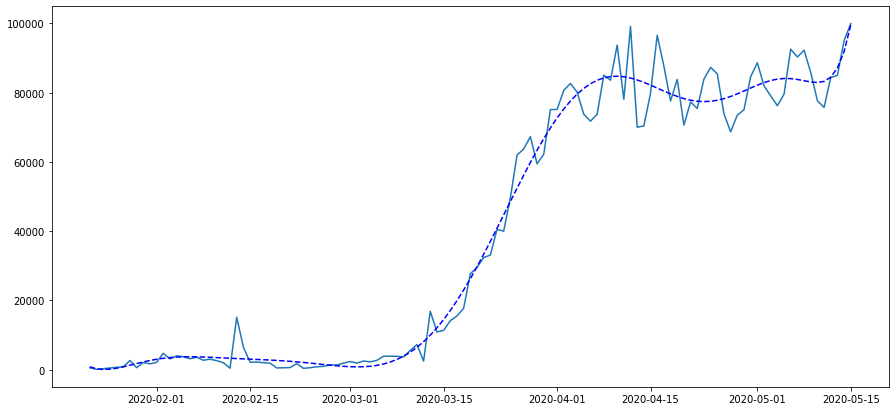

In [ ]:
from datetime import datetime

dta = df_total_diff

plt.figure(figsize=(15,7))
plt.plot(dta['ds'].values.astype('datetime64[D]'), dta['y'].values)

n_data = len(dta['ds'].values.astype('datetime64[D]'))

model = np.polyfit(x = np.arange(n_data), y = np.array(dta['y']), deg = min_deg)
polynom = np.poly1d(model)

plt.plot(dta['ds'].values.astype('datetime64[D]'), polynom( np.arange(n_data) ), 'b--')
plt.show()

Определим стационарность ряда с помощью теста Дики-Фулера

In [ ]:
trend = pd.DataFrame(data=(dta.y - polynom(np.arange(n_data)) ) )

# AdFuller: (Единичные корни)
# Original:
test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print ('ADF: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

ADF:  -6.114727188472097
p-value:  9.152701949358973e-08
Critical values:  {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
единичных корней нет, ряд стационарен


### График остатков того, что не приближает полином

In [ ]:
iplot([
       go.Scatter(x=trend.index,y=trend.y, name='trend')
     ])

## Найдём параметры p и q для модели

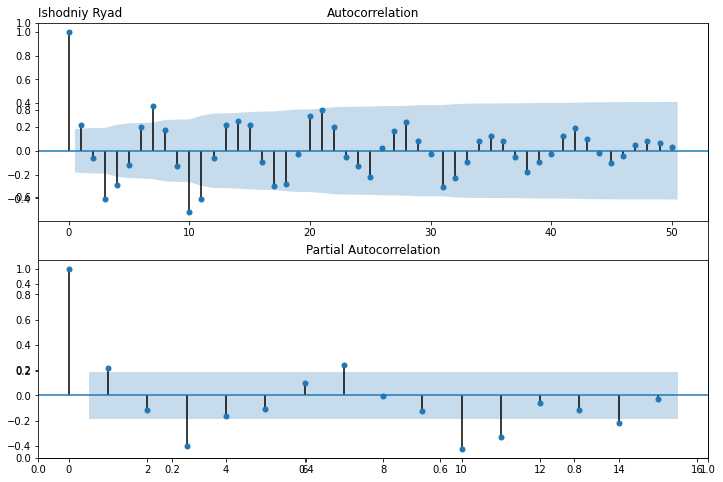

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
# ACF: p=25
fig = sm.graphics.tsa.plot_acf(trend.values.squeeze(), lags=50, ax=ax1)
# Take a look at Number of Lags!!!! lags=20, 25, 30, 100, ... etc.: coef_autocor = 0.75 at 21st
ax2 = fig.add_subplot(212)
# PACF: q=2
fig = sm.graphics.tsa.plot_pacf(trend, lags=15
                                    , ax=ax2)

По графикам видно, что p и q равны 1

In [ ]:
for_arima = df_total_diff.set_index('ds')
for_arima.index = pd.to_datetime(for_arima.index)
train_size = 30
src_data_model = for_arima[:-train_size]
src_data_model = src_data_model.resample("D").last()
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='D').fit(full_output=False, disp=0)

In [ ]:
from sklearn import metrics
pred = model.predict('2020-04-16','2020-05-15', typ='levels')
trn = for_arima[-train_size:]
print('MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(trn,pred)*100))
print('MAE: {:.2f}'.format(metrics.mean_absolute_error(trn,pred)))

MAPE: 13.70%
MAE: 10977.62


Немного поигравшись с параметрами у меня получилось, что p лучше взять двойкой.

In [ ]:
for_arima = df_total_diff.set_index('ds')
for_arima.index = pd.to_datetime(for_arima.index)
train_size = 30
src_data_model = for_arima[:-train_size]
src_data_model = src_data_model.resample("D").last()
model = sm.tsa.ARIMA(src_data_model, order=(2,1,1), freq='D').fit(full_output=False, disp=0)

In [ ]:
pred = model.predict('2020-04-16','2020-05-15', typ='levels')
trn = for_arima[-train_size:]
print('MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(trn,pred)*100))
print('MAE: {:.2f}'.format(metrics.mean_absolute_error(trn,pred)))

MAPE: 10.18%
MAE: 8097.40


Так у меня получилась ошибка MAPE равная 10.18% на ConfirmedCases

In [ ]:
#test = pd.DataFrame(pred, columns='y')
test = pred.reset_index(drop=False)
test = test.rename(columns={'index': 'ds'})
for_arima = for_arima.reset_index(drop=False)
iplot([
    go.Scatter(x=for_arima.ds , y=for_arima.y, name='fact'),
    go.Scatter(x=test.ds, y=test.iloc[:][0], name='forecast',line=dict(color='red',dash='dash')),
  ])

In [ ]:
pred = model.predict('2020-04-16','2021-04-16', typ='levels')
trn = for_arima[-train_size:]
test = pred.reset_index(drop=False)
test = test.rename(columns={'index': 'ds'})
for_arima = for_arima.reset_index(drop=False)
iplot([
    go.Scatter(x=for_arima.ds , y=for_arima.y, name='fact'),
    go.Scatter(x=test.ds, y=test.iloc[:][0], name='forecast',line=dict(color='red',dash='dash')),
  ])

In [ ]:
print('Прогноз ARIMA на количество обнаруженных заражений по всему миру: ',int(src_data_model.y.sum()+test.iloc[:][0].sum()))

Прогноз ARIMA на количество обнаруженных заражений по всему миру:  86131061


## Теперь рассмотрим Fatalities

Best degree 	14 with RMSE 669.9661826234587,
		 13 with MAE 361.01160438043155,
		 14 with R2 0.9491234180675936


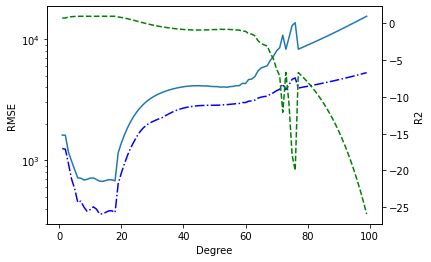

In [ ]:
dta = df_total_diff_death

n_data = len(dta['ds'].values.astype('datetime64[D]'))
X = np.arange(n_data).reshape(n_data, 1)
y = np.array(dta['y'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rmses = []
maes = []
r2_scores = []
degrees = np.arange(1, 100)
min_rmse, min_mae, min_r2, min_deg, min_deg_mae, min_deg_r2 = 1e10, 1e10, 0.01, 0, 0, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    
    # 1. RMSE:
    poly_mse = mean_squared_error(y_test, poly_predict) # Mean Square Error
    poly_rmse = np.sqrt(poly_mse) # Root Mean Square Root
    rmses.append(poly_rmse)
    
    # 2. MAE:
    poly_mae = mean_absolute_error(y_test, poly_predict)
    maes.append(poly_mae)
    
    # 3. R2 - score:
    poly_r2_score = r2_score(y_test.tolist(), poly_predict.tolist())
    r2_scores.append(poly_r2_score)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
    if min_mae > poly_mae:
        min_mae = poly_mae
        min_deg_mae = deg
    if min_r2 < poly_r2_score:
        min_r2 = poly_r2_score
        min_deg_r2 = deg

# Plot and present results
print('Best degree \t{} with RMSE {},\n\t\t {} with MAE {},\n\t\t {} with R2 {}'.format(min_deg, min_rmse, min_deg_mae, min_mae, min_deg_r2, min_r2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax2 = ax.twinx()
ax.plot(degrees, maes, 'b-.')
ax2.plot(degrees, r2_scores, 'g--')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax2.set_ylabel('R2')
ax.set_ylabel('MAE')
ax.set_ylabel('RMSE')
plt.show()

Далее нам необходимо подогнать наш полином под данные

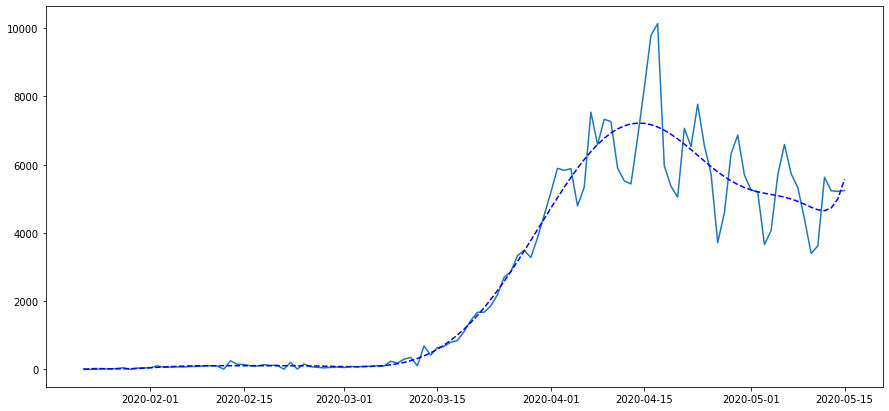

In [ ]:
dta = df_total_diff_death

plt.figure(figsize=(15,7))
plt.plot(dta['ds'].values.astype('datetime64[D]'), dta['y'].values)

n_data = len(dta['ds'].values.astype('datetime64[D]'))

model = np.polyfit(x = np.arange(n_data), y = np.array(dta['y']), deg = min_deg)
polynom = np.poly1d(model)

plt.plot(dta['ds'].values.astype('datetime64[D]'), polynom( np.arange(n_data) ), 'b--')
plt.show()

Определим стационарность ряда с помощью теста Дики-Фулера

In [ ]:
trend = pd.DataFrame(data=(dta.y - polynom(np.arange(n_data)) ) )

# AdFuller: (Единичные корни)
# Original:
test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print ('ADF: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

ADF:  -6.071096287977774
p-value:  1.1503636350919338e-07
Critical values:  {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
единичных корней нет, ряд стационарен


### График остатков того, что не приближает полином

In [ ]:
iplot([
       go.Scatter(x=trend.index,y=trend.y, name='trend')
     ])

## Найдём параметры p и q для модели

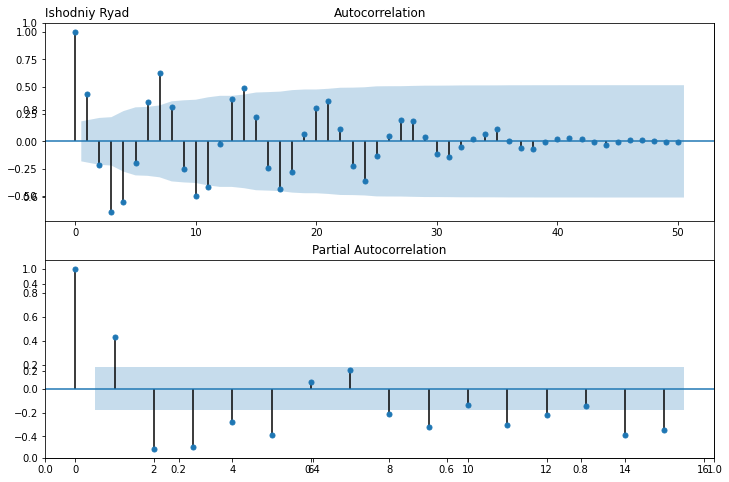

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
# ACF: p=25
fig = sm.graphics.tsa.plot_acf(trend.values.squeeze(), lags=50, ax=ax1)
# Take a look at Number of Lags!!!! lags=20, 25, 30, 100, ... etc.: coef_autocor = 0.75 at 21st
ax2 = fig.add_subplot(212)
# PACF: q=2
fig = sm.graphics.tsa.plot_pacf(trend, lags=15
                                    , ax=ax2)

По графикам видно, что p и q равны 5 и 4 соответственно

In [ ]:
for_arima = df_total_diff_death.set_index('ds')
for_arima.index = pd.to_datetime(for_arima.index)
train_size = 30
src_data_model = for_arima[:-train_size]
src_data_model = src_data_model.resample("D").last()
model = sm.tsa.ARIMA(src_data_model, order=(5,1,4), freq='D').fit(full_output=False, disp=0)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [ ]:

pred = model.predict('2020-04-16','2020-05-15', typ='levels')
trn = for_arima[-train_size:]
print('MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(trn,pred)*100))
print('MAE: {:.2f}'.format(metrics.mean_absolute_error(trn,pred)))

MAPE: 55.96%
MAE: 2835.73


Так у меня получилась ошибка MAPE равная 55.96% на Fatalities

In [ ]:
#test = pd.DataFrame(pred, columns='y')
test = pred.reset_index(drop=False)
test = test.rename(columns={'index': 'ds'})
for_arima = for_arima.reset_index(drop=False)
iplot([
    go.Scatter(x=for_arima.ds , y=for_arima.y, name='fact'),
    go.Scatter(x=test.ds, y=test.iloc[:][0], name='forecast',line=dict(color='red',dash='dash')),
  ])

Это лучший прогноз, что мне удалось получить с ARIMA 

## Посмотрим что будет через год

In [ ]:
pred = model.predict('2020-04-16','2021-04-16', typ='levels')
trn = for_arima[-train_size:]
test = pred.reset_index(drop=False)
test = test.rename(columns={'index': 'ds'})
for_arima = for_arima.reset_index(drop=False)
iplot([
    go.Scatter(x=for_arima.ds , y=for_arima.y, name='fact'),
    go.Scatter(x=test.ds, y=test.iloc[:][0], name='forecast',line=dict(color='red',dash='dash')),
  ])

In [ ]:
print('Прогноз ARIMA на количество обнаруженных заражений по всему миру: ',int(src_data_model.y.sum()+test.iloc[:][0].sum()))

Прогноз ARIMA на количество обнаруженных заражений по всему миру:  9139481


## Выводы по Total

### Проанализировав данные и попытавшись их спрогнозировать их разыми способами мы получили следующие результат прогнозов на тестовых данных :


---


**Prophet (ошибка прогноза на тесте в MAPE):** \
Прогноз ConfirmedCases: 9.83% \
Прогноз Fatalities: 50.48% \
**ARIMA:** \
Прогноз ConfirmedCases: 10.18% \
Прогноз Fatalities: 55.96% \


---
**Численные прогнозы на год вперёд** \
**Prophet:** \
Прогноз ConfirmedCases: 109 млн \
Прогноз Fatalities: 8.5 млн \
**ARIMA:** \
Прогноз ConfirmedCases: 86 млн \
Прогноз Fatalities: 9.1 млн 

---


### У нас получились довольно схожие результаты, но у профета всё таки немного лучше. В целом через профет прогнозировать гораздо легче и он интуитивно понятный.



#Анализ по России (Валерия Богданова)

In [ ]:
data_rus = pd.DataFrame(data[data.Country_Region == 'Russia'])
data_rus.index = np.arange(1, len(data_rus) + 1)

In [ ]:
data_rus

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
1,NaN,Russia,2020-01-22,0.0,0.0
2,NaN,Russia,2020-01-23,0.0,0.0
3,NaN,Russia,2020-01-24,0.0,0.0
4,NaN,Russia,2020-01-25,0.0,0.0
5,NaN,Russia,2020-01-26,0.0,0.0
...,...,...,...,...,...
111,NaN,Russia,2020-05-11,221344.0,2009.0
112,NaN,Russia,2020-05-12,232243.0,2116.0
113,NaN,Russia,2020-05-13,242271.0,2212.0
114,NaN,Russia,2020-05-14,252245.0,2305.0


In [ ]:
iplot([
    go.Scatter(x=data_rus.Date , y=data_rus.ConfirmedCases, name='confirmed cases'),
    go.Scatter(x=data_rus.Date , y=data_rus.Fatalities, name='fatalities')
]);

plt.show()

Видим, что кумулятивные данные плохо отражают суть и плохо подходят для прогнозирования, выделим в них каждодневные изменения

##Каждодневные изменения

In [ ]:
data_rus_confirm = data_rus[['Date', 'ConfirmedCases']]
data_rus_confirm.columns = ['ds', 'y']
data_rus_fatal = data_rus[['Date', 'Fatalities']]
data_rus_fatal.columns = ['ds', 'y']
data_rus_confirm.loc[:,'y'] = data_rus_confirm.y.diff().fillna(data_rus_confirm.y)
data_rus_fatal.loc[:,'y'] = data_rus_fatal.y.diff().fillna(data_rus_fatal.y)

In [ ]:
data_rus_confirm.tail()

,ds,y
111,2020-05-11,11656.0
112,2020-05-12,10899.0
113,2020-05-13,10028.0
114,2020-05-14,9974.0
115,2020-05-15,10598.0


In [ ]:
data_rus_fatal.tail()

,ds,y
111,2020-05-11,94.0
112,2020-05-12,107.0
113,2020-05-13,96.0
114,2020-05-14,93.0
115,2020-05-15,113.0


In [ ]:
iplot([
    go.Scatter(x=data_rus_confirm.ds , y=data_rus_confirm.y, name='confirmed cases')
]);

plt.show()

In [ ]:
iplot([
    go.Scatter(x=data_rus_fatal.ds , y=data_rus_fatal.y, name='fatalities')
]);

plt.show()

Видим, что такие данные уже лучше показывают заболеваемость в 2020 году

## Обучение модели Prophet

Настроим Prophet отдельно для confirmed cases и для fatalities

### Confirmed Cases

In [ ]:
train_size = int(len(data_rus_confirm)*0.8)
predictions_period = len(data_rus_confirm)  - train_size

m = Prophet()
m.fit(data_rus_confirm[:train_size])

future = m.make_future_dataframe(periods=predictions_period, freq = 'd')
forecast = m.predict(future)

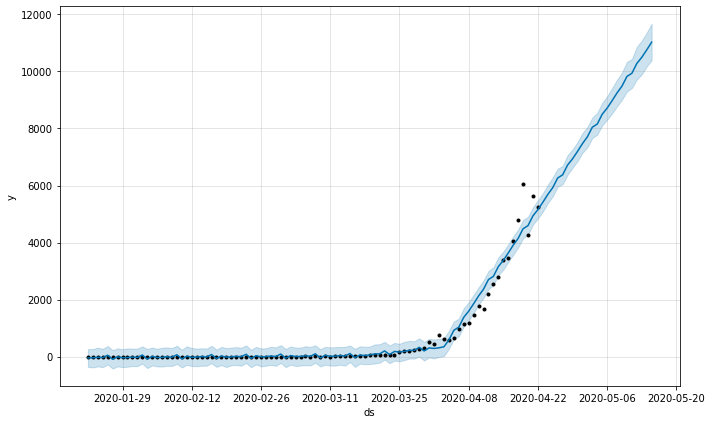

In [ ]:
m.plot(forecast)
plt.show()

In [ ]:
border_date = data_rus_confirm.iloc[train_size].ds
iplot([
    go.Scatter(x=data_rus_confirm.ds , y=data_rus_confirm.y, name='fact'),
    go.Scatter(x=forecast.ds, y=forecast.yhat, name='forecast'),
    go.Scatter(x=[border_date, border_date], y=[0,max(data_rus_confirm.y)], name='for', line=dict(color='green',dash='dash'), 
               mode='lines')

  ])

forecast['e'] = data_rus_confirm['y'] - forecast['yhat']
forecast['p'] = 100 * forecast['e']/data_rus_confirm['y']

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(forecast[-predictions_period:]['p'])),2))+'%')

print ('MAE - абсолютная ошибка', round(np.mean(abs(forecast[-predictions_period:]['e'])),0))

MAPE - ошибка в процентах 10.7%
MAE - абсолютная ошибка 974.0


In [ ]:
m = Prophet()
m.fit(data_rus_confirm)

future = m.make_future_dataframe(periods=30, freq = 'd')
forecast = m.predict(future)
forecast.tail()[['ds','yhat']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
140,2020-06-10,19322.342843
141,2020-06-11,19627.533468
142,2020-06-12,19972.665166
143,2020-06-13,20404.528814
144,2020-06-14,20805.882890


Прогноз дает 20.000 человек, однако статистика говорит о том, что в тот момент было уже в 2 раза больше зараженных

### Fatalities

In [ ]:
m = Prophet()
m.fit(data_rus_fatal[:train_size])

In [ ]:
predictions_period = len(data_rus_fatal)  - train_size
future = m.make_future_dataframe(periods=predictions_period, freq = 'd')
forecast = m.predict(future)

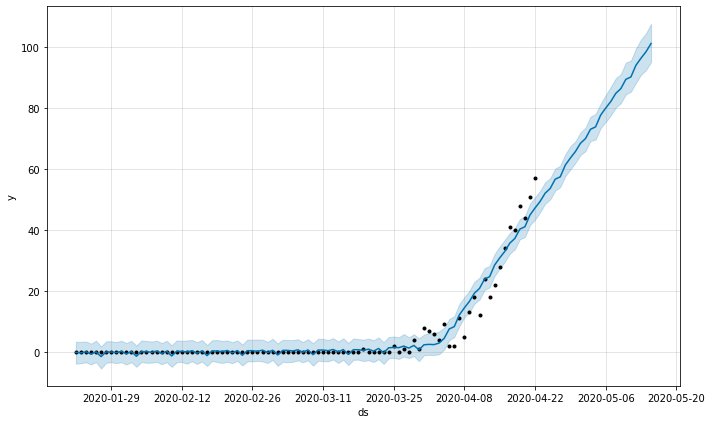

In [ ]:
m.plot(forecast)
plt.show()

In [ ]:
iplot([
    go.Scatter(x=data_rus_fatal.ds , y=data_rus_fatal.y, name='fact'),
    go.Scatter(x=forecast.ds, y=forecast.yhat, name='forecast'),
    go.Scatter(x=[border_date, border_date], y=[0,max(data_rus_fatal.y)], name='for', line=dict(color='green',dash='dash'), 
               mode='lines')
  ])

forecast['e'] = data_rus_fatal['y'] - forecast['yhat']
forecast['p'] = 100 * forecast['e']/data_rus_fatal['y']

print ('MAPE - ошибка в процентах', str(round(np.mean(abs(forecast[-predictions_period:]['p'])),2))+'%')

print ('MAE - абсолютная ошибка', round(np.mean(abs(forecast[-predictions_period:]['e'])),0))

MAPE - ошибка в процентах 15.48%
MAE - абсолютная ошибка 12.0


In [ ]:
m = Prophet()
m.fit(data_rus_fatal)
future = m.make_future_dataframe(periods=30, freq = 'd')
forecast = m.predict(future)
forecast.tail()[['ds','yhat']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
140,2020-06-10,174.486347
141,2020-06-11,175.545869
142,2020-06-12,180.200717
143,2020-06-13,179.519905
144,2020-06-14,181.449407


Прогноз количества смертей на более длительный срок работает крайне плохо: на самом деле тогда каждый день умирали уже около 5.000 человек

## Перебор гиперпараметров

Несмотря на довольно маленькую ошибку в Prophet без каких либо параметров, переберем различные их комбинации и посмотрим, можно ли добиться лучшего качества

### Для confirmed cases

In [ ]:
params_grid = {
               'changepoint_range': [0.8,0.9,0.95],
              'seasonality_prior_scale' :[1,10,20,80,100],
              'n_changepoints' : [10,25],
               'interval_width':[0.7, 0.8, 0.9]
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 90


In [ ]:

model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in tqdm(grid):
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(
       # changepoint_prior_scale = p['changepoint_prior_scale'],
                        n_changepoints = p['n_changepoints'],
                         changepoint_range = p['changepoint_range'],
                       seasonality_prior_scale = p['seasonality_prior_scale'],
                         interval_width=p['interval_width']
                         )


    train_model.fit(data_rus_confirm[:train_size])
    train_forecast = train_model.make_future_dataframe(periods=predictions_period, freq='d')
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    #Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    #MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    cmp_df = train_forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data_rus_confirm.set_index('ds'))

    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100 * cmp_df['e']/cmp_df['y']


    abs_p = abs(cmp_df[-predictions_period:]['p'])
    abs_e = abs(cmp_df[-predictions_period:]['e'])
    yhat_low = cmp_df['yhat_lower']
    MAPE = round(np.mean(abs(cmp_df[-predictions_period:]['p'])),2)
  
  
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,10.30,"{'changepoint_range': 0.9, 'interval_width': 0..."
1,10.30,"{'changepoint_range': 0.9, 'interval_width': 0..."
2,10.30,"{'changepoint_range': 0.9, 'interval_width': 0..."
3,10.31,"{'changepoint_range': 0.9, 'interval_width': 0..."
4,10.31,"{'changepoint_range': 0.9, 'interval_width': 0..."


Видим, что значительных улучшений не наблюдается. Добавление праздников также не привело к каким либо улучшениям

### Для fatalities

In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in tqdm(grid):
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(
                        n_changepoints = p['n_changepoints'],
                         changepoint_range = p['changepoint_range'],
                       seasonality_prior_scale = p['seasonality_prior_scale'],
                         interval_width=p['interval_width'])


    train_model.fit(data_rus_fatal[:train_size])
    train_forecast = train_model.make_future_dataframe(periods=predictions_period, freq='d')
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    
    cmp_df = train_forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data_rus_fatal.set_index('ds'))

    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100 * cmp_df['e']/cmp_df['y']


    abs_p = abs(cmp_df[-predictions_period:]['p'])
    abs_e = abs(cmp_df[-predictions_period:]['e'])
    yhat_low = cmp_df['yhat_lower']
    MAPE = round(np.mean(abs(cmp_df[-predictions_period:]['p'])),2)
  
  
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,14.98,"{'changepoint_range': 0.9, 'interval_width': 0..."
1,14.98,"{'changepoint_range': 0.9, 'interval_width': 0..."
2,14.98,"{'changepoint_range': 0.9, 'interval_width': 0..."
3,14.98,"{'changepoint_range': 0.9, 'interval_width': 0..."
4,14.98,"{'changepoint_range': 0.9, 'interval_width': 0..."


Также не видим значимых улучшений.

##ARIMA

### Confirmed Cases

Построим ARIMA модель на данных

In [ ]:
min_rmse, min_mae, min_r2, min_deg, min_deg_mae, min_deg_r2 = 1e10, 1e10, 0.01, 0, 0, 0
n_data = len(data_rus_confirm.ds.values.astype('datetime64[D]'))
model = np.polyfit(x = np.arange(n_data), y = np.array(data_rus_confirm.y), deg = min_deg)
polynom = np.poly1d(model)

Выделим тренд

In [ ]:
trend = pd.DataFrame(data=(data_rus_confirm.y - polynom(np.arange(n_data)) ) )
y1diff = trend.diff(periods=1).dropna() # Первая разность ряда
# y1diff = np.array([trend[1] - trend[0], trend[2] - trend[1], ...])

Проведем тест Дики-Фулера для определения параметра d

In [ ]:
# AdFuller: (Единичные корни)
# Original:
test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print ('ADF: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[1]> 0.05: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

# Единичные корни: Первая разность ряда
test = sm.tsa.stattools.adfuller(y1diff.iloc[:,0].values)
print ('ADF: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[1]> 0.05: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')


ADF:  1.4470869913105127
p-value:  0.9973178960961354
Critical values:  {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}
есть единичные корни, ряд не стационарен
ADF:  -2.8818673009356717
p-value:  0.04749758049879021
Critical values:  {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}
единичных корней нет, ряд стационарен


Видим, что при первой разности наш ряд становится стационарным, значит берем d = 1

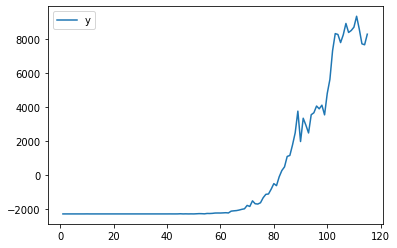

In [ ]:
trend.plot()

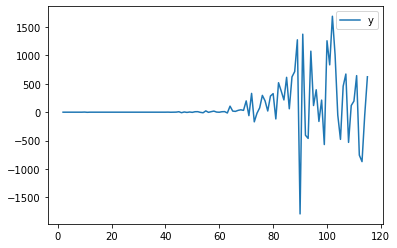

In [ ]:
y1diff.plot()

Визуализировав тренд и первую его разность видим, что так он действительно похож на стационарный

Нарисуем графики ACF и PACF для определения начальных q и p

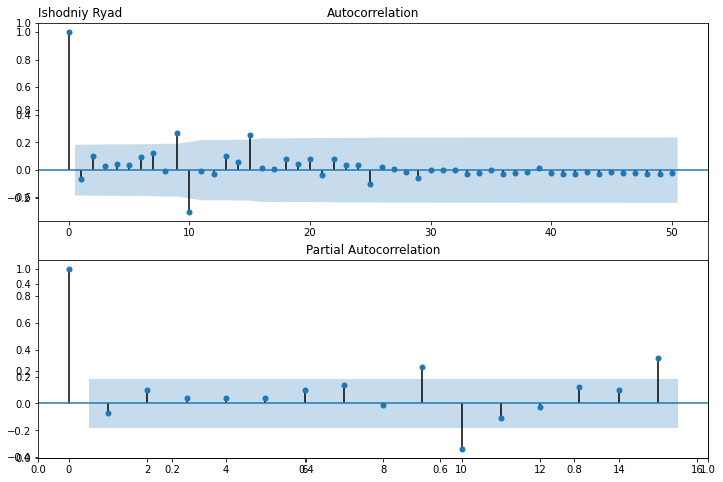

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
# ACF: p=25
fig = sm.graphics.tsa.plot_acf(y1diff.values.squeeze(), lags=50, ax=ax1)
# Take a look at Number of Lags!!!! lags=20, 25, 30, 100, ... etc.: coef_autocor = 0.75 at 21st
ax2 = fig.add_subplot(212)
# PACF: q=2
fig = sm.graphics.tsa.plot_pacf(y1diff, lags=15
                                    , ax=ax2)


Видим только 1 лаг, сильно отличный от нуля. Берем начальные значения q=1, p=1

In [ ]:
for_arima = data_rus_confirm.set_index('ds')

src_data_model = for_arima[:train_size]
model = sm.tsa.ARIMA(src_data_model, order=(3,1,1)).fit(full_output=False, disp=0)

Однако начальные приближения не так хорошо подходили для наших данных, как p,d,q=3,1,1

In [ ]:
pred = model.predict('2020-04-23','2020-05-15', typ='levels')
trn = for_arima['2020-04-23':]

In [ ]:
print('MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(trn,pred)*100))
print('MAE: {:.2f}'.format(metrics.mean_absolute_error(trn,pred)))

MAPE: 14.91%
MAE: 1469.69


In [ ]:
#test = pd.DataFrame(pred, columns='y')
test = pred.reset_index(drop=False)
test = test.rename(columns={'index': 'ds'})
for_arima = for_arima.reset_index(drop=False)

In [ ]:
iplot([
    go.Scatter(x=for_arima.ds , y=for_arima.y, name='fact'),
    go.Scatter(x=test.ds, y=test.iloc[:][0], name='forecast',line=dict(color='red',dash='dash')),
  ])

Видим MAPE около 15%, что хуже, чем в Prophet (около 10%), однако не намного

In [ ]:
for_arima = data_rus_confirm.set_index('ds')

src_data_model = for_arima
model = sm.tsa.ARIMA(src_data_model, order=(3,1,1)).fit(full_output=False, disp=0)
pred = model.predict('2020-04-23','2020-06-14', typ='levels')
pred.tail()

2020-06-10    29264.961610
2020-06-11    30288.827350
2020-06-12    31332.880569
2020-06-13    32396.897348
2020-06-14    33480.656003
Freq: D, dtype: float64

Видим, что несмотря на большую ошибку, прогноз на месяц намного более похож на реальные значения (40.000)

### Fatalities

In [ ]:
n_data = len(data_rus_fatal.ds.values.astype('datetime64[D]'))
model = np.polyfit(x = np.arange(n_data), y = np.array(data_rus_fatal.y), deg = min_deg)
polynom = np.poly1d(model)

Также выделяем тренд и необходимые разности

In [ ]:
trend = pd.DataFrame(data=(data_rus_fatal.y - polynom(np.arange(n_data)) ) )
y1diff = trend.diff(periods=1).dropna() # Первая разность ряда
y2diff = trend.diff(periods=2).dropna() # Вторая разность ряда 
y2diff = y1diff.diff(periods=1).dropna() # Вторая разность ряда

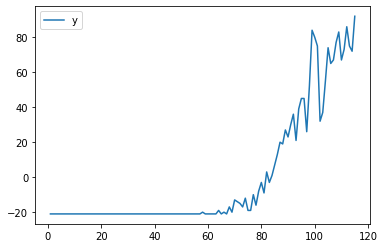

In [ ]:
trend.plot()

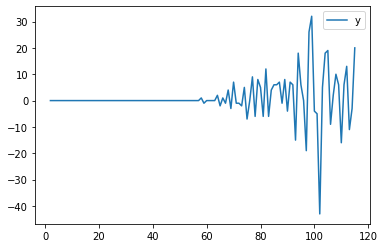

In [ ]:
y1diff.plot()

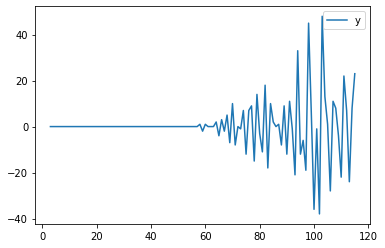

In [ ]:
y2diff.plot()

In [ ]:
# AdFuller: (Единичные корни)
# Original:
test = sm.tsa.stattools.adfuller(trend.iloc[:,0].values)
print ('ADF: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[1]> 0.05: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

# Единичные корни: Первая разность ряда
test = sm.tsa.stattools.adfuller(y1diff.iloc[:,0].values)
print ('ADF: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[1]> 0.05: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

# Единичные корни: Первая разность ряда
test = sm.tsa.stattools.adfuller(y2diff.iloc[:,0].values)
print ('ADF: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[1]> 0.05: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

ADF:  0.5727326001160165
p-value:  0.9869238913792123
Critical values:  {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}
есть единичные корни, ряд не стационарен
ADF:  -0.8511112012089568
p-value:  0.8036458184471496
Critical values:  {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}
есть единичные корни, ряд не стационарен
ADF:  -7.461118443313538
p-value:  5.35074257341854e-11
Critical values:  {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}
единичных корней нет, ряд стационарен


Получили, что только вторая разность стационарна, берем d=2

---



Смотрим графики ACF, PACF

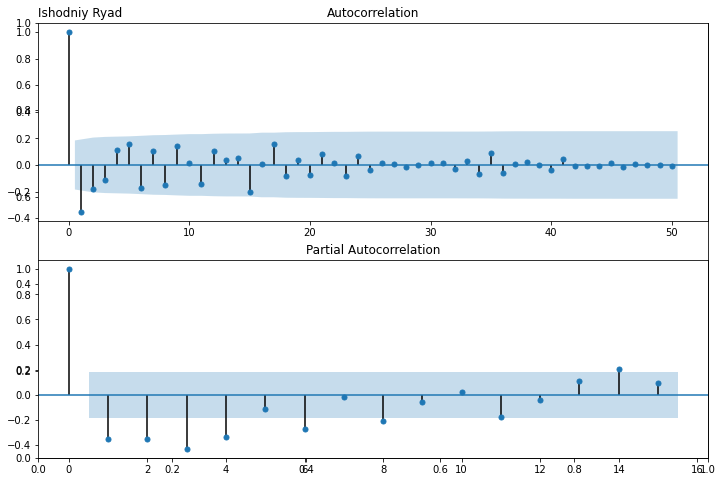

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.title('Ishodniy Ryad', loc='left')
ax1 = fig.add_subplot(211)
# ACF: p=25
fig = sm.graphics.tsa.plot_acf(y2diff.values.squeeze(), lags=50, ax=ax1)
# Take a look at Number of Lags!!!! lags=20, 25, 30, 100, ... etc.: coef_autocor = 0.75 at 21st
ax2 = fig.add_subplot(212)
# PACF: q=2
fig = sm.graphics.tsa.plot_pacf(y2diff, lags=15
                                    , ax=ax2)

Берем начальные приближения p=4, q=1

In [ ]:
for_arima = data_rus_fatal.set_index('ds')

src_data_model = for_arima[:train_size]
model = sm.tsa.ARIMA(src_data_model, order=(4,1,1)).fit(full_output=False, disp=0)

Начальный параметр d оказался не самым лучшим, больше всего подошел d = 1

In [ ]:
pred = model.predict('2020-04-23','2020-05-15', typ='levels')
trn = for_arima['2020-04-23':]

In [ ]:
print('MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(trn,pred)*100))
print('MAE: {:.2f}'.format(metrics.mean_absolute_error(trn,pred)))

MAPE: 17.81%
MAE: 12.90


In [ ]:
test = pred.reset_index(drop=False)
test = test.rename(columns={'index': 'ds'})
for_arima = for_arima.reset_index(drop=False)

In [ ]:
iplot([
    go.Scatter(x=for_arima.ds , y=for_arima.y, name='fact'),
    go.Scatter(x=test.ds, y=test.iloc[:][0], name='forecast',line=dict(color='red',dash='dash')),
  ])

Получили ошибку MAPE = 17%, что не сильно отличается от результатов Prophet (15%)

In [ ]:
for_arima = data_rus_fatal.set_index('ds')

src_data_model = for_arima
model = sm.tsa.ARIMA(src_data_model, order=(4,1,1)).fit(full_output=False, disp=0)
pred = model.predict('2020-04-23','2020-06-14', typ='levels')
pred.tail()

2020-06-10    131.549438
2020-06-11    132.496651
2020-06-12    133.443172
2020-06-13    134.390632
2020-06-14    135.338896
Freq: D, dtype: float64

Здесь прогноз также работает довольно плохо, так как реальное количество смертей составляет около 5.000

## Выводы по России

### Проанализировав данные и попытавшись их спрогнозировать их разыми способами мы получили следующие результат прогнозов на тестовых данных :


---


**Prophet (ошибка прогноза на тесте в MAPE):** \
Прогноз ConfirmedCases: 10.7% \
Прогноз Fatalities: 15.48% \
**ARIMA:** \
Прогноз ConfirmedCases: 14.91% \
Прогноз Fatalities: 17.81% \


---
**Численные прогнозы на месяц вперёд** \
**Prophet:** \
Прогноз ConfirmedCases: 20.805 \
Прогноз Fatalities: 181 \
**ARIMA:** \
Прогноз ConfirmedCases: 33.480 \
Прогноз Fatalities: 135 

---
**Реальные данные** \
ConfirmedCases: 40.000 \
Fatalities: 5.000 

---


### У нас получились довольно схожие результаты. Несмотря на меньшую ошибку у Prophet на наших данных, прогноз на месяц ARIMA по ConfirmedCases более похож на реальные данные. 